<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 340, '日付': '2021-05-24T08:00:00.000Z'},
 {'小計': 542, '日付': '2021-05-25T08:00:00.000Z'},
 {'小計': 743, '日付': '2021-05-26T08:00:00.000Z'},
 {'小計': 684, '日付': '2021-05-27T08:00:00.000Z'},
 {'小計': 614, '日付': '2021-05-28T08:00:00.000Z'},
 {'小計': 539, '日付': '2021-05-29T08:00:00.000Z'},
 {'小計': 448, '日付': '2021-05-30T08:00:00.000Z'},
 {'小計': 260, '日付': '2021-05-31T08:00:00.000Z'},
 {'小計': 471, '日付': '2021-06-01T08:00:00.000Z'},
 {'小計': 487, '日付': '2021-06-02T08:00:00.000Z'},
 {'小計': 508, '日付': '2021-06-03T08:00:00.000Z'},
 {'小計': 472, '日付': '2021-06-04T08:00:00.000Z'},
 {'小計': 436, '日付': '2021-06-05T08:00:00.000Z'},
 {'小計': 351, '日付': '2021-06-06T08:00:00.000Z'},
 {'小計': 235, '日付': '2021-06-07T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-06-03 17:00:00+09:00,371,0,508,2021-06-03 17:00:00+09:00
2021-06-04 17:00:00+09:00,340,0,472,2021-06-04 17:00:00+09:00
2021-06-05 17:00:00+09:00,363,0,436,2021-06-05 17:00:00+09:00
2021-06-06 17:00:00+09:00,319,0,351,2021-06-06 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-06-03 17:00:00+09:00,371,0,508,2021-06-03 17:00:00+09:00,396.285714,2774.0,0.0,0.0,475.285714,3327.0
2021-06-04 17:00:00+09:00,340,0,472,2021-06-04 17:00:00+09:00,386.285714,2704.0,0.0,0.0,455.000000,3185.0
2021-06-05 17:00:00+09:00,363,0,436,2021-06-05 17:00:00+09:00,378.285714,2648.0,0.0,0.0,440.285714,3082.0
2021-06-06 17:00:00+09:00,319,0,351,2021-06-06 17:00:00+09:00,377.285714,2641.0,0.0,0.0,426.428571,2985.0
2021-06-07 17:00:00+09:00,0,0,235,2021-06-07 17:00:00+09:00,311.571429,2181.0,0.0,0.0,422.857143,2960.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-05-24 17:00:00+09:00,533,0,340,2021-05-24 17:00:00+09:00,503.571429,3525.0,0.0,0.0,638.142857,4467.0,'21w21,Mon
2021-05-25 17:00:00+09:00,455,0,542,2021-05-25 17:00:00+09:00,487.285714,3411.0,0.0,0.0,611.000000,4277.0,'21w21,Tue
2021-05-26 17:00:00+09:00,424,0,743,2021-05-26 17:00:00+09:00,468.000000,3276.0,0.0,0.0,607.714286,4254.0,'21w21,Wed
2021-05-27 17:00:00+09:00,426,0,684,2021-05-27 17:00:00+09:00,459.000000,3213.0,0.0,0.0,585.000000,4095.0,'21w21,Thu
2021-05-28 17:00:00+09:00,410,0,614,2021-05-28 17:00:00+09:00,445.571429,3119.0,0.0,0.0,580.000000,4060.0,'21w21,Fri
2021-05-29 17:00:00+09:00,419,0,539,2021-05-29 17:00:00+09:00,432.714286,3029.0,0.0,0.0,571.000000,3997.0,'21w21,Sat
2021-05-30 17:00:00+09:00,326,0,448,2021-05-30 17:00:00+09:00,427.571429,2993.0,0.0,0.0,558.571429,3910.0,'21w21,Sun
2021-05-31 17:00:00+09:00,460,0,260,2021-05-31 17:00:00+09:00,417.142857,2920.0,0.0,0.0,547.142857,3830.0,'21w22,Mon
2021-06-01 17:00:00+09:00,400,0,471,2021-06-01 17:00:00+09:00,409.285714,2865.0,0.0,0.0,537.000000,3759.0,'21w22,Tue
2021-06-02 17:00:00+09:00,388,0,487,2021-06-02 17:00:00+09:00,404.142857,2829.0,0.0,0.0,500.428571,3503.0,'21w22,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-05-23 17:00:00+09:00,649.428571,4546
2021-05-30 17:00:00+09:00,558.571429,3910
2021-06-06 17:00:00+09:00,426.428571,2985
2021-06-07 17:00:00+09:00,235.000000,235
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-05-24 17:00:00+09:00,533,0,340,2021-05-24 17:00:00+09:00,503.571429,3525.0,0.0,0.0,638.142857,4467.0,'21w21,Mon,NaN,NaN
2021-05-25 17:00:00+09:00,455,0,542,2021-05-25 17:00:00+09:00,487.285714,3411.0,0.0,0.0,611.000000,4277.0,'21w21,Tue,NaN,NaN
2021-05-26 17:00:00+09:00,424,0,743,2021-05-26 17:00:00+09:00,468.000000,3276.0,0.0,0.0,607.714286,4254.0,'21w21,Wed,NaN,NaN
2021-05-27 17:00:00+09:00,426,0,684,2021-05-27 17:00:00+09:00,459.000000,3213.0,0.0,0.0,585.000000,4095.0,'21w21,Thu,NaN,NaN
2021-05-28 17:00:00+09:00,410,0,614,2021-05-28 17:00:00+09:00,445.571429,3119.0,0.0,0.0,580.000000,4060.0,'21w21,Fri,NaN,NaN
2021-05-29 17:00:00+09:00,419,0,539,2021-05-29 17:00:00+09:00,432.714286,3029.0,0.0,0.0,571.000000,3997.0,'21w21,Sat,NaN,NaN
2021-05-30 17:00:00+09:00,326,0,448,2021-05-30 17:00:00+09:00,427.571429,2993.0,0.0,0.0,558.571429,3910.0,'21w21,Sun,558.571429,3910.0
2021-05-31 17:00:00+09:00,460,0,260,2021-05-31 17:00:00+09:00,417.142857,2920.0,0.0,0.0,547.142857,3830.0,'21w22,Mon,NaN,NaN
2021-06-01 17:00:00+09:00,400,0,471,2021-06-01 17:00:00+09:00,409.285714,2865.0,0.0,0.0,537.000000,3759.0,'21w22,Tue,NaN,NaN
2021-06-02 17:00:00+09:00,388,0,487,2021-06-02 17:00:00+09:00,404.142857,2829.0,0.0,0.0,500.428571,3503.0,'21w22,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

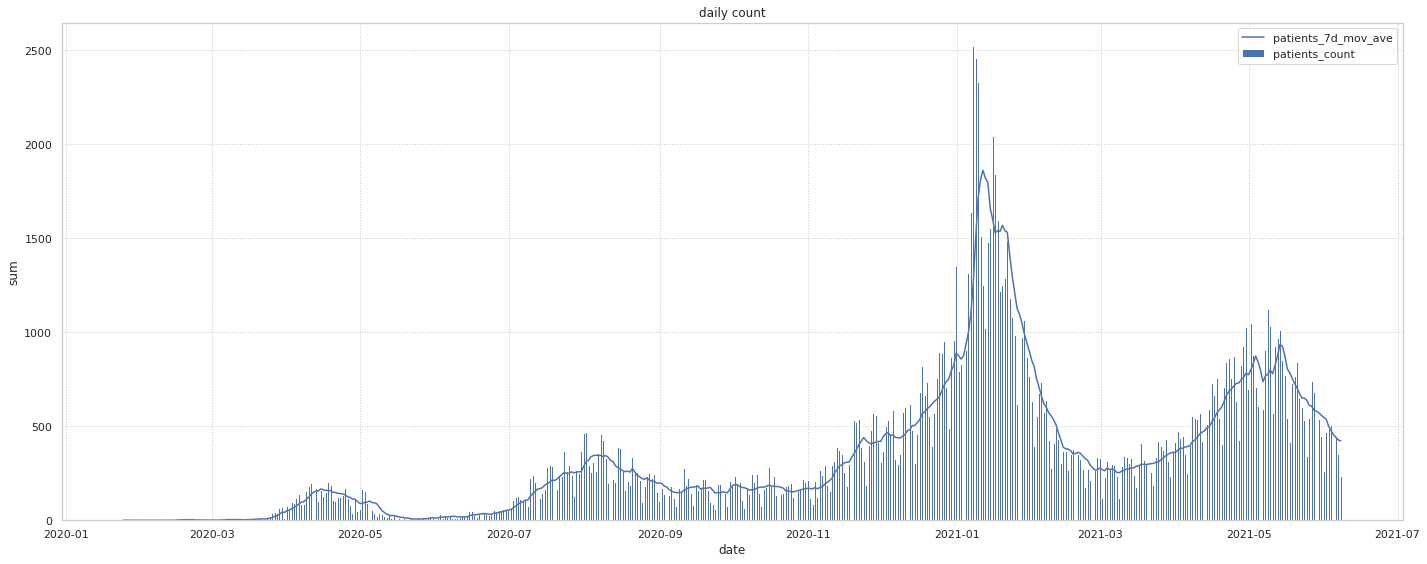

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
486,1.621843e+09,2021,5,24,0,1,0,0,0,0,0,486,0,412,533,503.571429,3525.0,0,0.0,0.0,340,638.142857,4467.0
487,1.621930e+09,2021,5,25,0,0,0,0,0,1,0,487,0,413,455,487.285714,3411.0,0,0.0,0.0,542,611.000000,4277.0
488,1.622016e+09,2021,5,26,0,0,0,0,0,0,1,488,0,414,424,468.000000,3276.0,0,0.0,0.0,743,607.714286,4254.0
489,1.622102e+09,2021,5,27,0,0,0,0,1,0,0,489,0,415,426,459.000000,3213.0,0,0.0,0.0,684,585.000000,4095.0
490,1.622189e+09,2021,5,28,1,0,0,0,0,0,0,490,0,416,410,445.571429,3119.0,0,0.0,0.0,614,580.000000,4060.0
491,1.622275e+09,2021,5,29,0,0,1,0,0,0,0,491,0,417,419,432.714286,3029.0,0,0.0,0.0,539,571.000000,3997.0
492,1.622362e+09,2021,5,30,0,0,0,1,0,0,0,492,0,418,326,427.571429,2993.0,0,0.0,0.0,448,558.571429,3910.0
493,1.622448e+09,2021,5,31,0,1,0,0,0,0,0,493,0,419,460,417.142857,2920.0,0,0.0,0.0,260,547.142857,3830.0
494,1.622534e+09,2021,6,1,0,0,0,0,0,1,0,494,0,420,400,409.285714,2865.0,0,0.0,0.0,471,537.000000,3759.0
495,1.622621e+09,2021,6,2,0,0,0,0,0,0,1,495,0,421,388,404.142857,2829.0,0,0.0,0.0,487,500.428571,3503.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            501 non-null    float64
 1   year                 501 non-null    int64  
 2   month                501 non-null    int64  
 3   day                  501 non-null    int64  
 4   Fri                  501 non-null    uint8  
 5   Mon                  501 non-null    uint8  
 6   Sat                  501 non-null    uint8  
 7   Sun                  501 non-null    uint8  
 8   Thu                  501 non-null    uint8  
 9   Tue                  501 non-null    uint8  
 10  Wed                  501 non-null    uint8  
 11  passed               501 non-null    int64  
 12  emergency            501 non-null    int64  
 13  em_passed            501 non-null    int64  
 14  contacts_count       501 non-null    int64  
 15  contacts_7d_mov_ave  501 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.010000e+02,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,1.601453e+09,2020.315369,5.704591,15.724551,0.143713,0.143713,0.143713,0.143713,0.141717,0.141717,0.141717,250.000000,0.097804,181.538922,667.832335,666.351535,4664.453094,735.566866,735.566866,5148.968064,327.175649,324.948189,2274.604790
std,1.250817e+07,0.465127,3.313693,8.904155,0.351149,0.351149,0.351149,0.351149,0.349108,0.349108,0.349108,144.770508,0.297347,136.742492,436.447078,423.699009,2965.905052,870.073350,780.336370,5462.354588,371.353935,351.233945,2458.667727
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590653e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,51.000000,387.000000,388.428571,2719.000000,0.000000,0.000000,0.000000,60.000000,69.000000,483.000000
50%,1.601453e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000,0.000000,176.000000,536.000000,552.857143,3870.000000,302.000000,793.000000,5551.000000,218.000000,211.857143,1483.000000
75%,1.612253e+09,2021.000000,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.000000,0.000000,301.000000,779.000000,761.285714,5329.000000,1351.000000,1356.571429,9496.000000,446.000000,445.142857,3116.000000
max,1.623053e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,500.000000,1.000000,426.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.804821,0.080296,-0.006884,-0.004249,0.004249,-0.001416,0.001416,0.002810,-0.002810,-1.492948e-18,1.000000e+00,-0.346040,0.995442,-0.289326,-0.271415,-0.271410,-0.531328,-0.572857,-0.572857,0.627541,0.671702,0.671717
year,8.048211e-01,1.000000,-0.524659,-0.047074,0.003593,0.003593,0.003593,0.003593,-0.004819,-0.004819,-4.818558e-03,8.048211e-01,-0.223465,0.824552,-0.275596,-0.252313,-0.252310,-0.574357,-0.640406,-0.640406,0.601056,0.661506,0.661507
month,8.029601e-02,-0.524659,1.000000,-0.018760,-0.013287,0.000463,-0.008131,-0.004693,0.012057,0.005142,8.599408e-03,8.029601e-02,-0.118794,0.040341,0.051145,0.037536,0.037539,0.204932,0.257881,0.257881,-0.112265,-0.151877,-0.151857
day,-6.884091e-03,-0.047074,-0.018760,1.000000,0.012686,-0.003945,-0.000107,0.007569,0.001002,-0.011866,-5.432258e-03,-6.884091e-03,-0.001135,-0.005793,-0.012508,-0.011872,-0.011876,0.010327,-0.004053,-0.004053,-0.007926,0.003440,0.003425
Fri,-4.248960e-03,0.003593,-0.013287,0.012686,1.000000,-0.167832,-0.167832,-0.167832,-0.166469,-0.166469,-1.664687e-01,-4.248960e-03,-0.000803,-0.003241,-0.017460,-0.003724,-0.003723,0.033655,-0.002301,-0.002301,0.046432,-0.002027,-0.002035
Mon,4.248960e-03,0.003593,0.000463,-0.003945,-0.167832,1.000000,-0.167832,-0.167832,-0.166469,-0.166469,-1.664687e-01,4.248960e-03,-0.000803,0.004382,0.034100,-0.002414,-0.002413,0.139165,-0.002301,-0.002301,-0.130838,0.000330,0.000332
Sat,-1.416320e-03,0.003593,-0.008131,-0.000107,-0.167832,-0.167832,1.000000,-0.167832,-0.166469,-0.166469,-1.664687e-01,-1.416320e-03,-0.000803,-0.000700,0.045676,-0.003027,-0.003026,-0.165085,-0.002301,-0.002301,0.060818,-0.001019,-0.001025
Sun,1.416320e-03,0.003593,-0.004693,0.007569,-0.167832,-0.167832,-0.167832,1.000000,-0.166469,-0.166469,-1.664687e-01,1.416320e-03,-0.000803,0.001841,-0.024115,-0.002414,-0.002413,-0.152261,-0.002301,-0.002301,-0.037234,-0.000211,-0.000212
Thu,2.809627e-03,-0.004819,0.012057,0.001002,-0.166469,-0.166469,-0.166469,-0.166469,1.000000,-0.165116,-1.651163e-01,2.809627e-03,0.001077,0.001790,-0.004504,0.004607,0.004608,0.044212,0.003086,0.003086,0.081185,0.002148,0.002153
Tue,-2.809627e-03,-0.004819,0.005142,-0.011866,-0.166469,-0.166469,-0.166469,-0.166469,-0.165116,1.000000,-1.651163e-01,-2.809627e-03,0.001077,-0.003321,-0.021988,0.003141,0.003142,0.059442,0.003086,0.003086,-0.033916,-0.000169,-0.000165


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,1.622707e+09,0,0,0,0,1,0,0,496,0,422,371,0,508,475.285714,3327.0
497,1.622794e+09,1,0,0,0,0,0,0,497,0,423,340,0,472,455.000000,3185.0
498,1.622880e+09,0,0,1,0,0,0,0,498,0,424,363,0,436,440.285714,3082.0
499,1.622966e+09,0,0,0,1,0,0,0,499,0,425,319,0,351,426.428571,2985.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
496,1.622707e+09,496,0,508,475.285714,3327.0
497,1.622794e+09,497,0,472,455.000000,3185.0
498,1.622880e+09,498,0,436,440.285714,3082.0
499,1.622966e+09,499,0,351,426.428571,2985.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

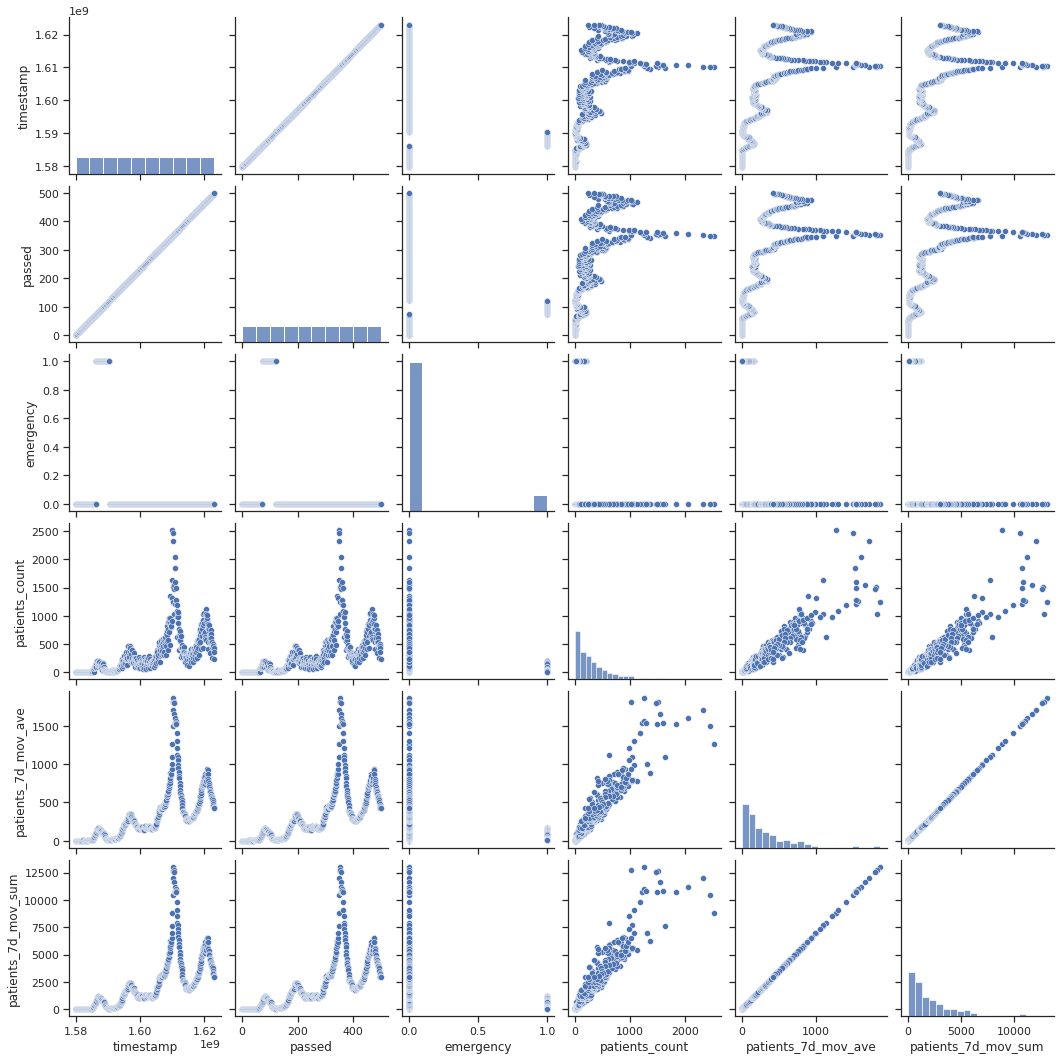

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
